In [1]:
import os
try:
    os.chdir(base_dir) #if the start up file has already been run, this will change the dir back to base
except NameError:
    base_dir = None #if the start up file hasn't been run yet, this will allow us to run this cell without crashing

In [2]:
%run ./startup_file.ipynb #run startup file and install libraries if necessary

# MONTHLY_CLIMA

## Author: haley synan

##### *Last run on 2024-07-25*

#### Objectives:
* data needed: observation level point data (*in-situ*) and satellite nc file grid
* interpolate point data to a regular grid (to match satellite grid)

#### Table of Contents
* [Load point data](#one)
* [Load satellite data](#two)
* [Load coastlines data](#three)
* [Subset data](#four)
* [Create grid](#five)
* [Interpolate data](#six) 
* [Visualize data](#seven)
* [Questions](#eight)

#### History: <br>
>* *7/23/2024: created* <br>
>* *7/24/2024: added high res coastlines for geopandas plotting* <br>
>* *7/25/2024: updated markdown notes, added TOC*

### Load in-situ point data <a class="anchor" id="one"></a>

In [3]:
import geopandas
import shapely
os.chdir(data_dir)
df = pd.read_csv('data_2000_2005.csv') #read data
df = df.drop('datetime',axis=1)
df.head() #view dataframe header

,lat,lon,date,depth,temp,sal,source,SA,CT,rho,mlp2,spiciness0,alpha,beta,month,tempAnomalies,salAnomalies,year
0,41.9714,-66.0782,20010214,0.992157,4.524,32.581,CTD,32.735703,4.544190,1025.815,33.099998,-1.301605,0.000102,0.000769,2,-0.755910,-0.165142,2001
1,41.9714,-66.0782,20010214,1.984309,4.524,32.588,CTD,32.742733,4.544048,1025.826,33.099998,-1.296677,0.000102,0.000769,2,-0.756052,-0.158112,2001
2,41.9714,-66.0782,20010214,2.976457,4.523,32.589,CTD,32.743729,4.542965,1025.831,33.099998,-1.295921,0.000102,0.000769,2,-0.757135,-0.157116,2001
3,41.9714,-66.0782,20010214,3.968599,4.519,32.593,CTD,32.747742,4.538846,1025.839,33.099998,-1.293732,0.000102,0.000769,2,-0.761254,-0.153103,2001
4,41.9714,-66.0782,20010214,4.960737,4.518,32.592,CTD,32.746735,4.537786,1025.843,33.099998,-1.294510,0.000102,0.000769,2,-0.762314,-0.154110,2001


In [6]:
#create project data folder to download the data to
#NOTE: WITH THE NEW VERSION OF STARTUP FILE THIS WILL BE OBSOLETE 
proj_data = '/Chlorophyll' #name of project
data_dir_fold = data_dir+proj_data #path for new folder 
isexist = os.path.exists(data_dir_fold) #check if path exists
if str(isexist) == 'False': #if path doesn't exist already, make it
    os.mkdir(data_dir_fold)

### Load satellite data <a class="anchor" id="two"></a>
Currently loading in OCCCI data - switch to PACE? 

In [5]:
os.chdir(data_dir_fold)

start_date = '2000-01-01' #(yyyy-mm-dd format)
end_date = '2000-01-31'

try:
    ds_target = xr.open_dataset('DD8_'+start_date.split('-')[0]+start_date.split('-')[1]+start_date.split('-')[2]+'_'+end_date.split('-')[0]+end_date.split('-')[1]+end_date.split('-')[2]+'.nc')
    ds_target
except FileNotFoundError: 
    url=''.join(['https://comet.nefsc.noaa.gov/erddap/griddap/occci_v6_daily_1km.nc?chlor_a%5B('+start_date+'T00:00:00Z):1:('+end_date+'T00:00:00Z)%5D%5B(34):1:(45)%5D%5B(-77):1:(-63)%5D'])
    s_date = url2date(url,nu=start_date) # for start date: nu = 1
    e_date = url2date(url,nu=end_date) #for end date: nu = 2   
    fname = "/DD8_" + s_date + '_'+ e_date + ".nc" #create unique filename 
    file = data_dir_fold+fname
    urllib.request.urlretrieve(url, file) #download data
    ds_target = xr.open_dataset(file, decode_cf=True) #open nc file 

### Load coastlines data (for plotting only) <a class="anchor" id="three"></a>
The native coastline resolution for the geopandas library is HORRIBLE... so download a better resolution to plot with :D 

In [7]:
from gadm import GADMDownloader

downloader = GADMDownloader(version="4.0")

country_name = "United States"
ad_level = 0
coastlines = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)

In [ ]:
#max_yr=max(df.year)
#min_yr=min(df.year)
#yr = []
#year = {}
#for x in range(min_yr,max_yr+1):
#    y = df[df.year==x]
#    yr.append(y)
#    year.update({x:year})


### Subset data <a class="anchor" id="four"></a>
Currently have the code looping through months only (manually have to do years).. will add to loop through years AND months 

In [8]:
#subset data 
year = 2001
df_sub = df[df.year == year] #subset by year 
mo = {}

for y in range(1,13): #create dictionary of months
    m = df_sub[df_sub.month == y]
    #month.append(m)
    mo.update({y: m})

gdf={}
for y in range(1,13):
    g = geopandas.GeoDataFrame(mo[y], 
            geometry=geopandas.points_from_xy(mo[y].lon, mo[y].lat),
            crs="EPSG:4326")
    gdf.update({y:g})

### Create grid <a class="anchor" id="five"></a>
SO FAR, the easiest way I've seen to grid the point data is using geopandas. However, I haven't quite figured out how to grid it DIRECTLY to the satellite grid. I've been creating an empty grid based on the satellite grid. I am not 100% sure its the exact same??

In [ ]:
#ds_target.attrs #look at attribute data 

In [9]:
# total area for the grid
ymin = -77.6875 #from nc file attributes 
ymax = -63.60416666666667 #from attributes 
xmin = 33.97916666666667 #from attributes 
xmax = 42.97916666666667 #from attributes 
#ymin, xmin, ymax, xmax= gdf.total_bounds
# how many cells across and down
#n_cells=30
cell_size =0.041666666666666664 #from attribute data 
# projection of the grid
crs="EPSG:4326" #wsg85 projection 
# create the cells in a loop
grid_cells = []
for x0 in np.arange(ymin, ymax+cell_size, cell_size ):
    for y0 in np.arange(xmin, xmax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

### Interpolate data  <a class="anchor" id="six"></a>

* uses ["sjoin"](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) for a spatial join between 2 geodataframes (the point data, and the target grid)
* uses ["dissolve"](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) to aggregate data by groups. For this I averaged the data found in each grid and then included the number of data points found in each grid

In [10]:
data ={}
for y in range(1,13):
    merged = geopandas.sjoin(gdf[y] , cell, how='left', op='within') #spatial join 
    merged['source']=1 #arbitrary variable used to calculate count
    count = merged.dissolve(by="index_right", aggfunc="count") #aggregate data by count
    dissolve = merged.dissolve(by="index_right", aggfunc='mean') #aggregate data by mean
    dd = geopandas.sjoin(cell,dissolve) # add polygon geometries
    dd.insert(2, 'count', count.lat) #add count data
    data.update({y:dd})

### Visualize data <a class="anchor" id="seven"></a>
Once the data is gridded, we have AVERAGED lat / lons (still technically point data) and polygon geometries. <br>
Below there is code to plot the gridded polygons (more accurate) using geopandas and plotting the averaged lat/lons using cartopy. 

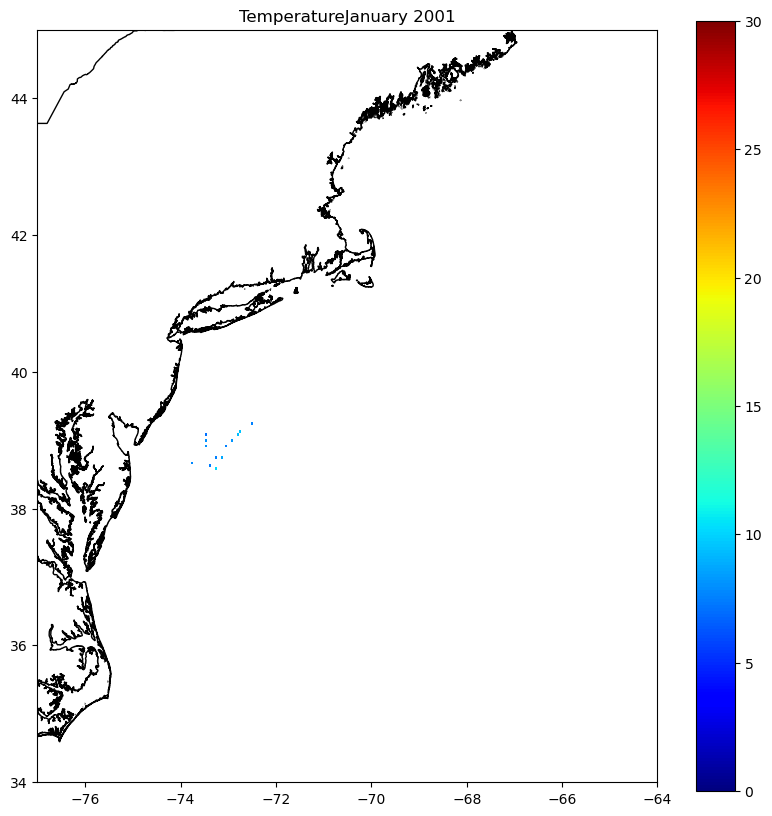

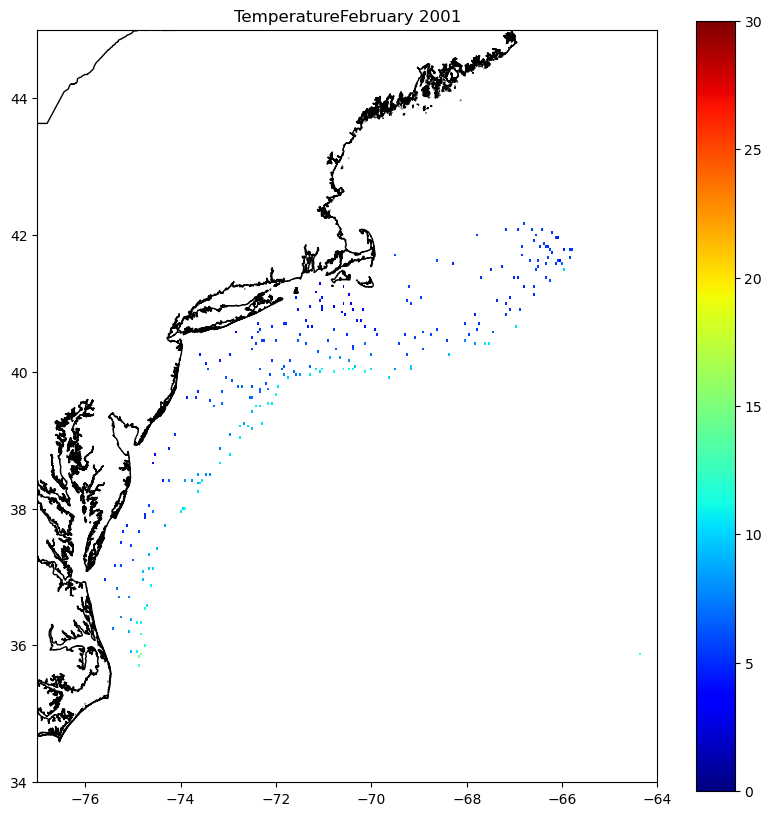

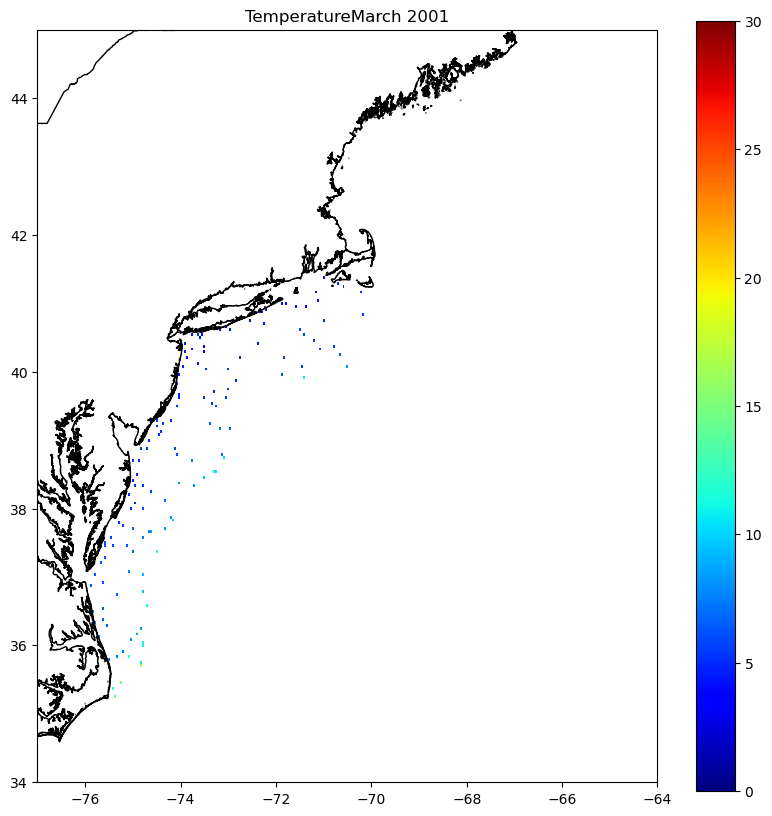

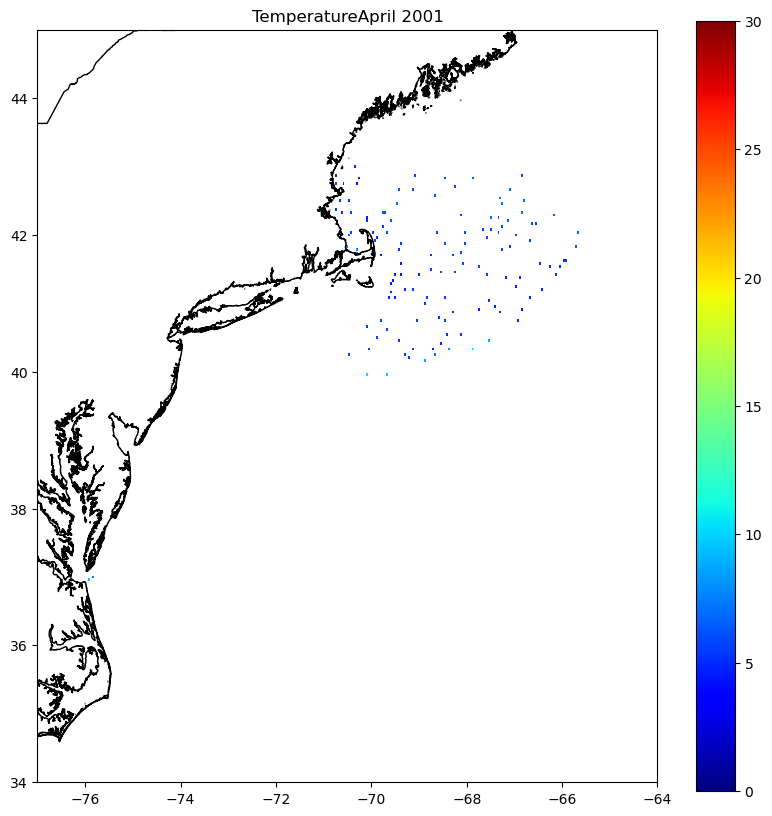

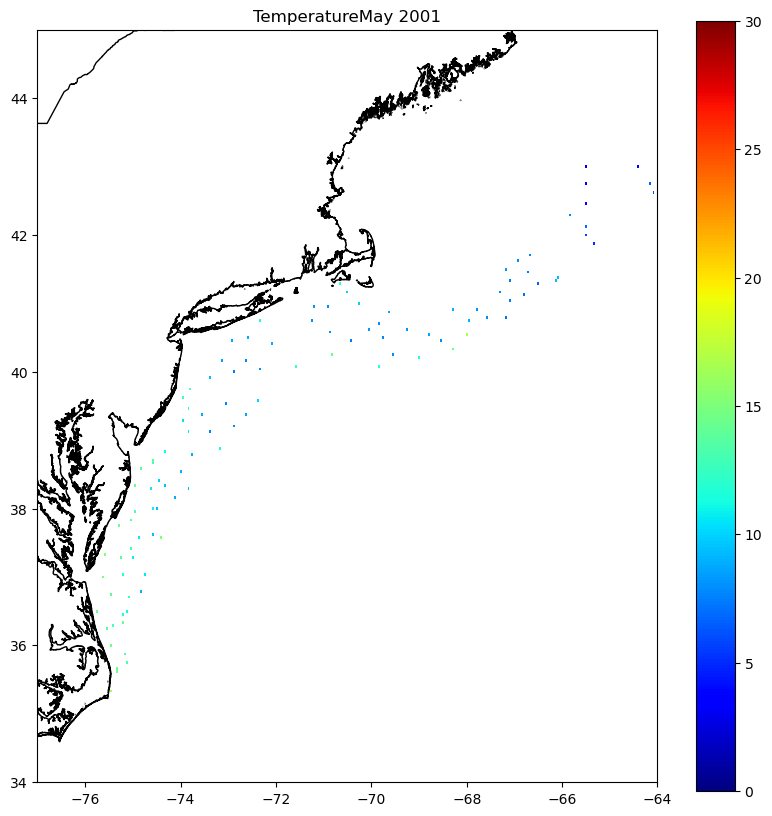

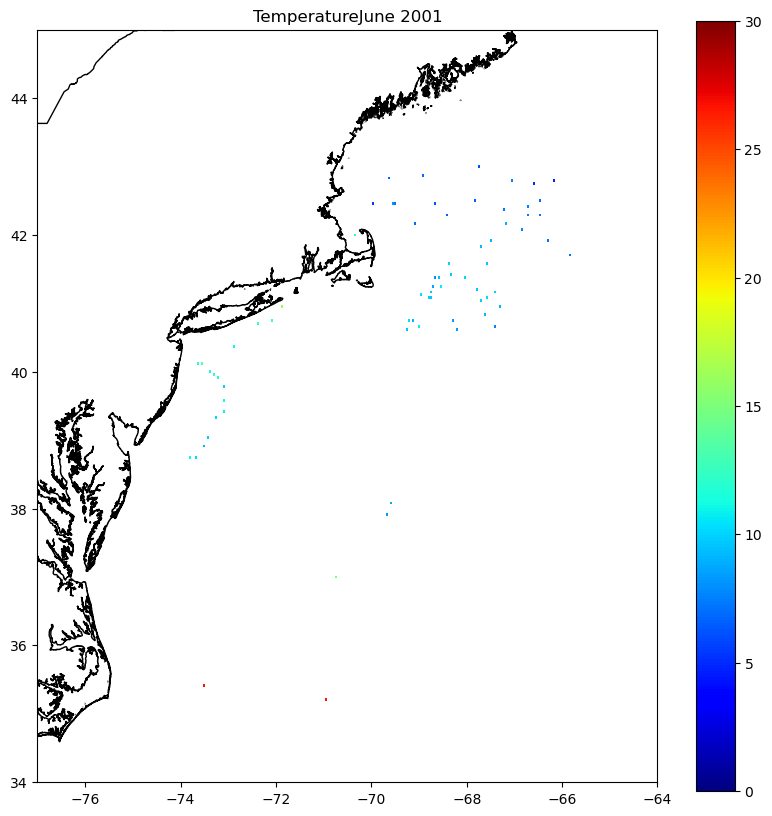

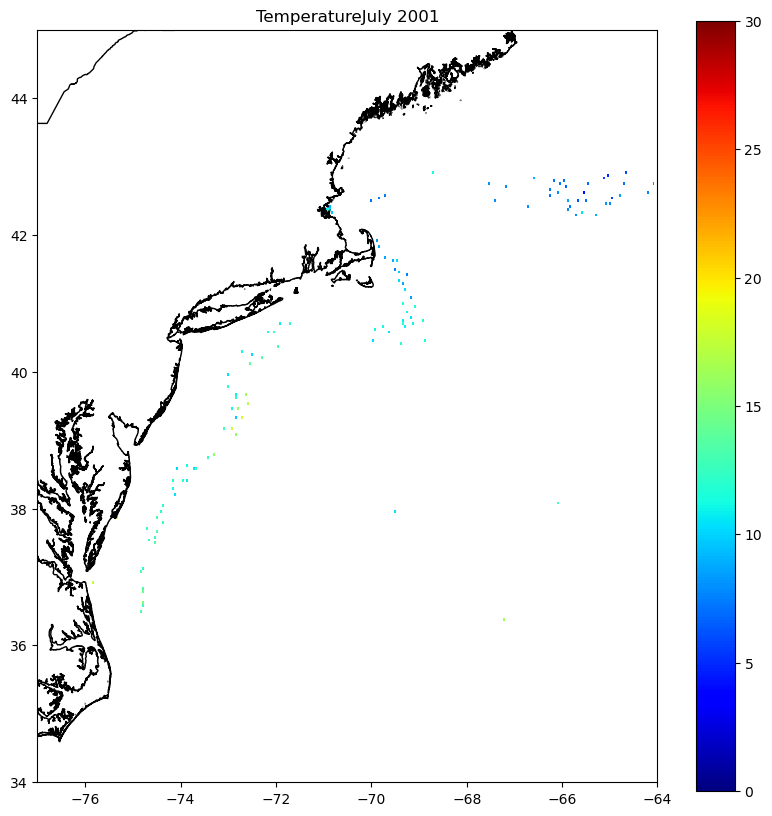

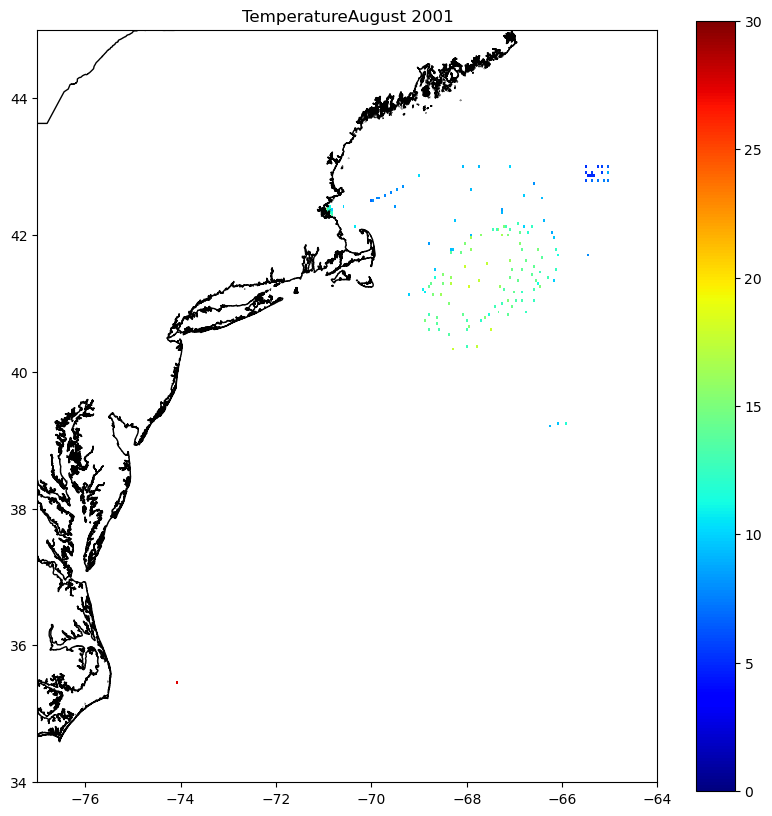

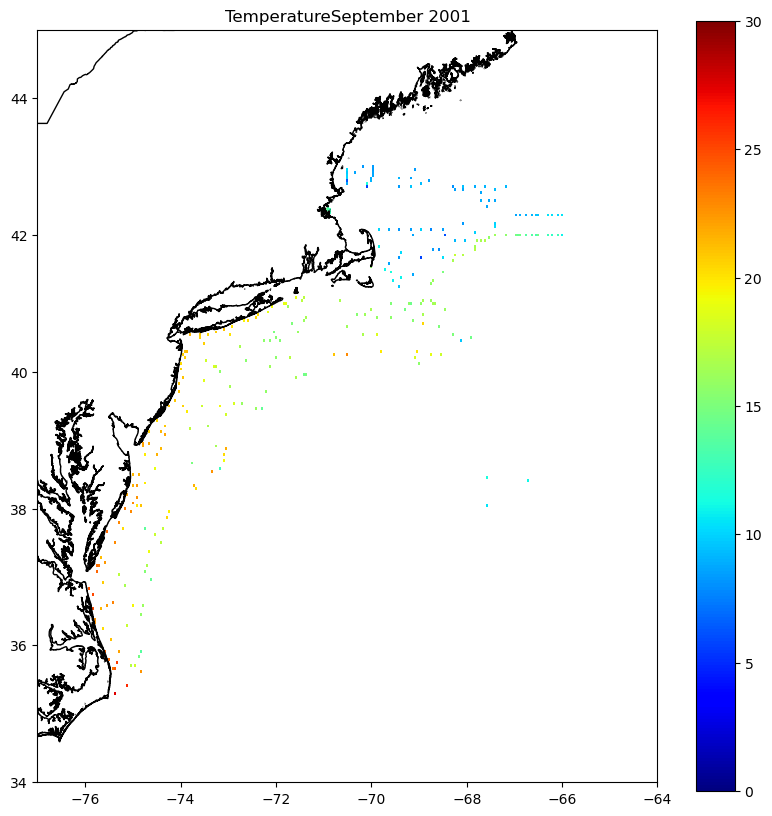

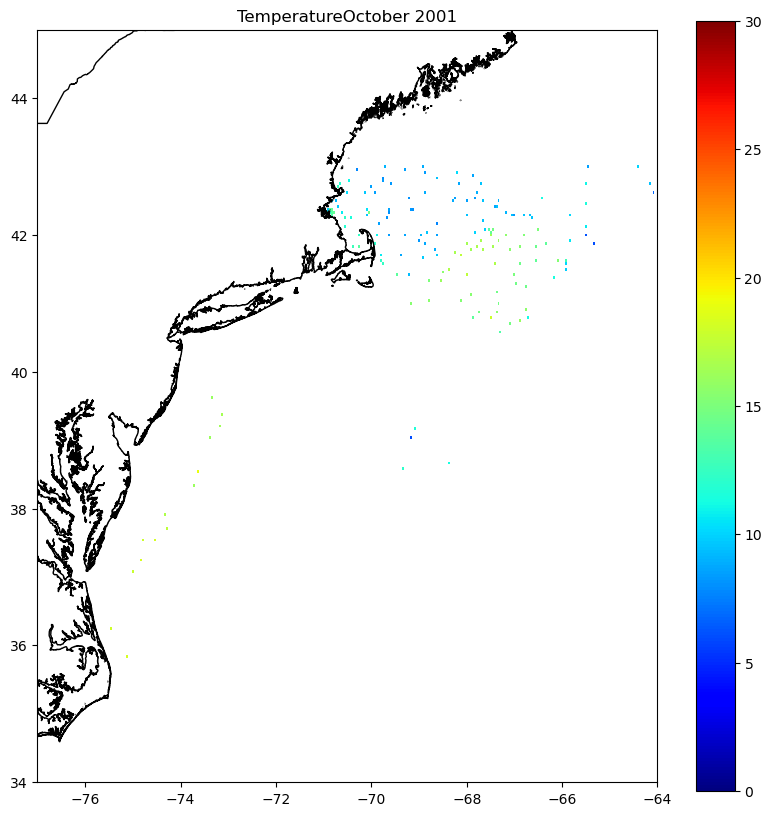

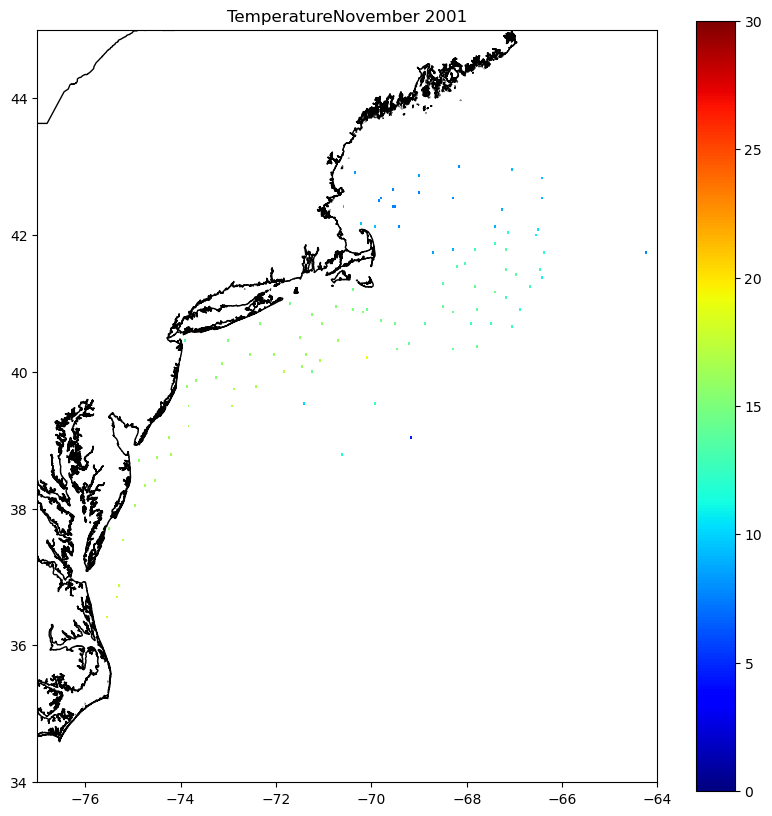

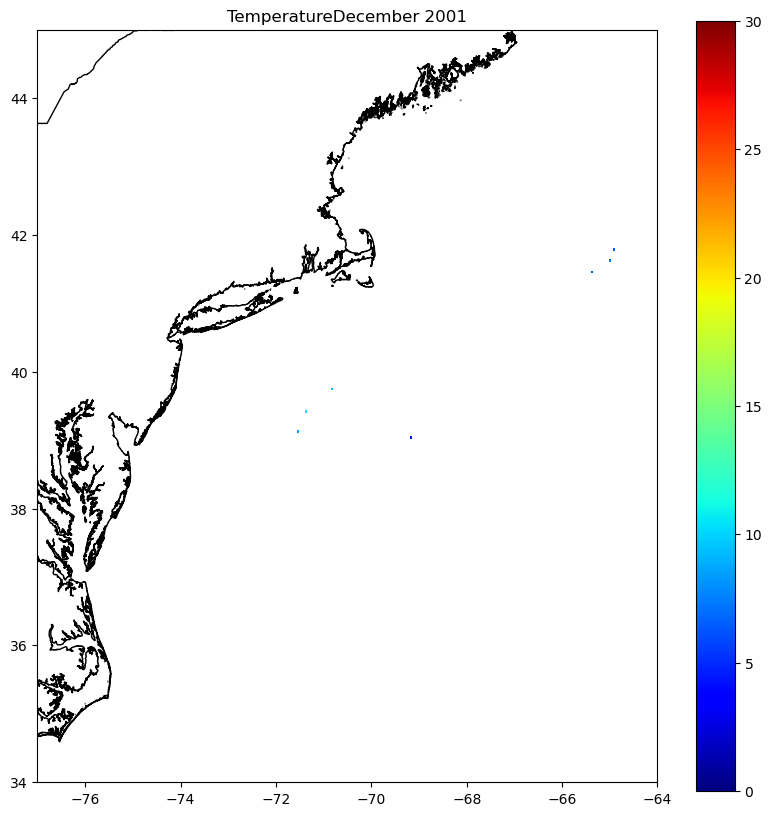

In [11]:
#PLOTTING WITH GEOPANDAS
month_name = ['na','January','February','March','April','May','June','July','August','September','October','November','December']
os.chdir(proj_dir)
#plotting with geopandas
for y in range(1,13):
    ax = data[y].plot(column='temp', figsize=(10, 10), cmap='jet', edgecolor="none", legend=True, vmin=0, vmax=30)
    ax.set_xlim([-77, -64])
    ax.set_ylim([34, 45])
    #world = geopandas.read_file('gadm41_USA_0.shp') #downloaded gadm data from https://gadm.org/download_country.html
    coastlines.to_crs(data[y].crs).plot(ax=ax, color='none', edgecolor='black')
    plt.title('Temperature'+month_name[y]+' ' +str(year))
    

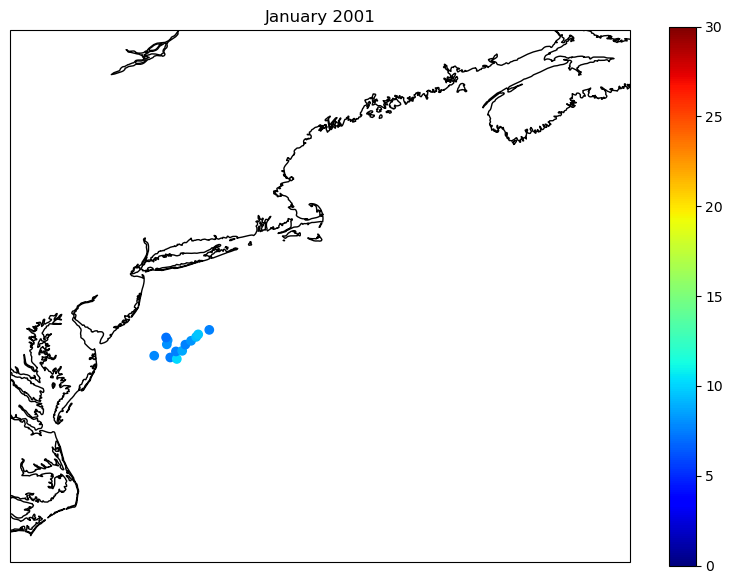

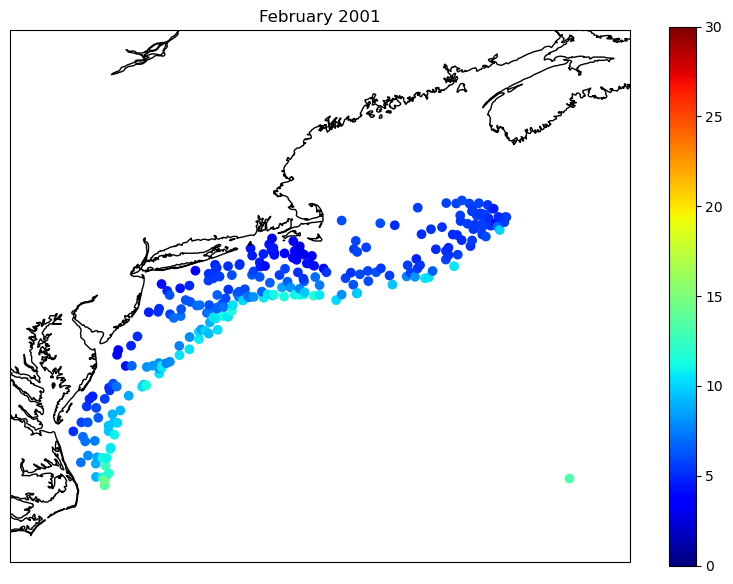

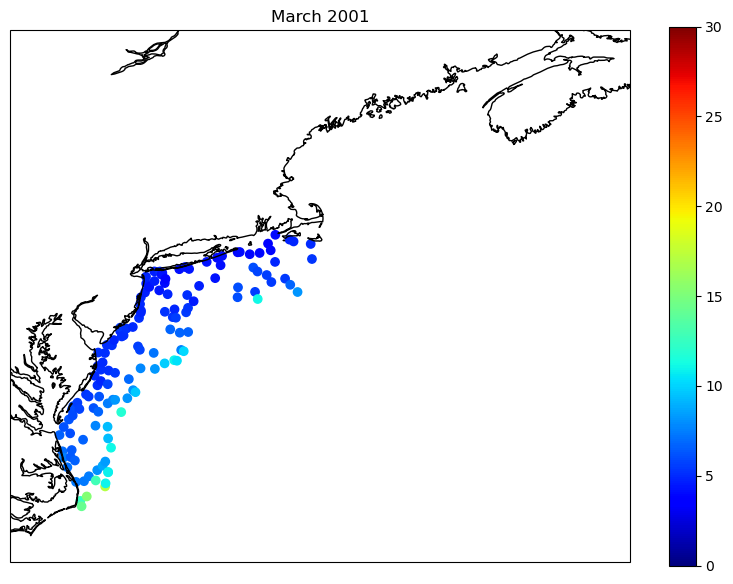

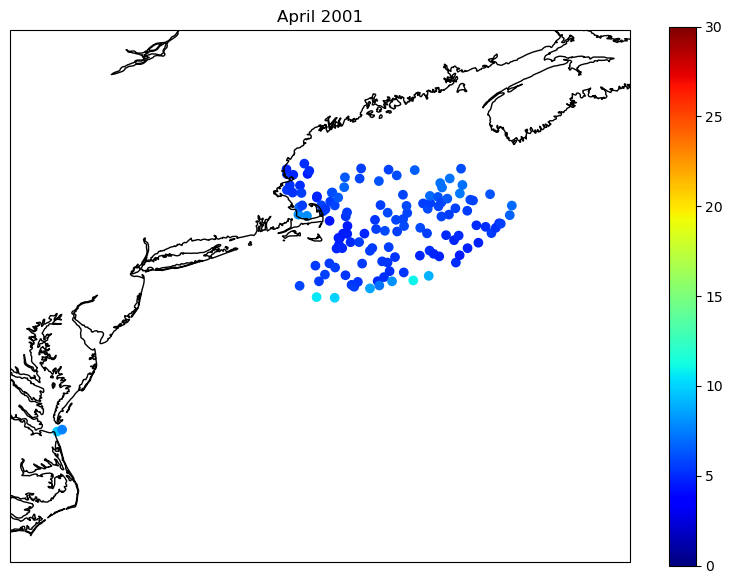

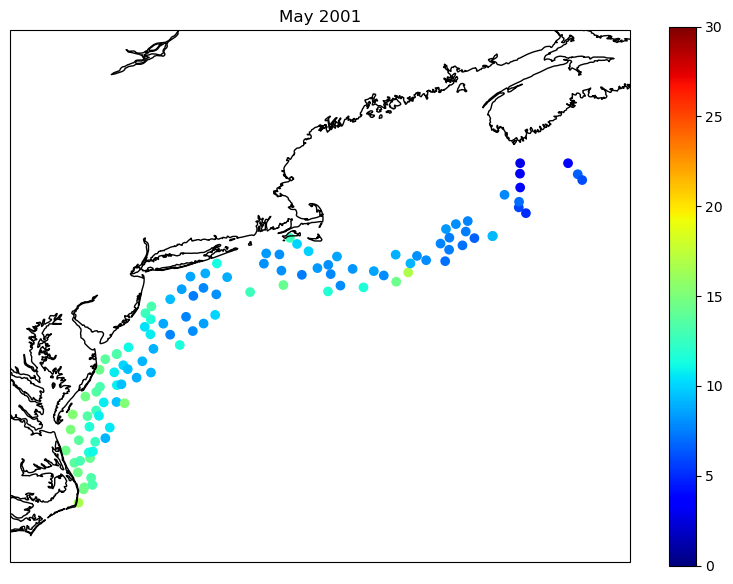

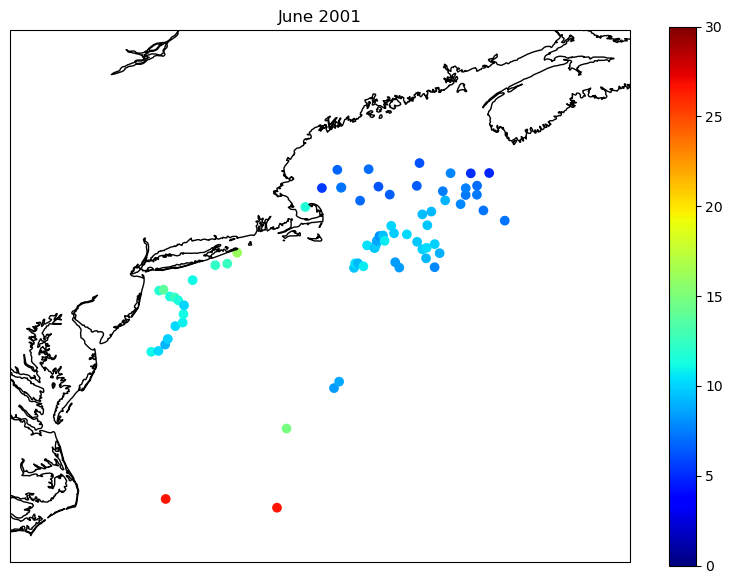

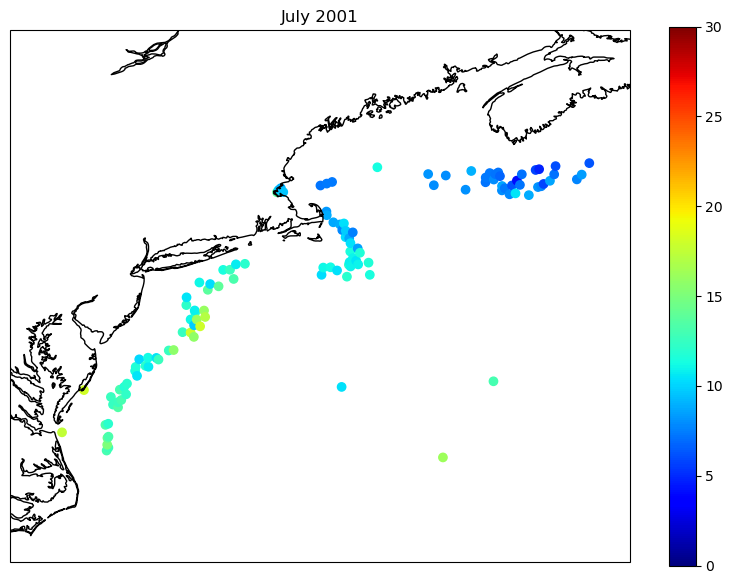

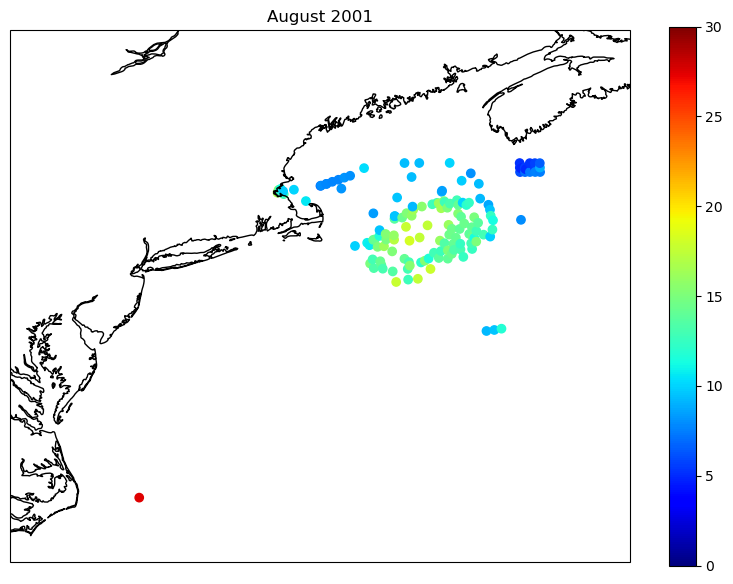

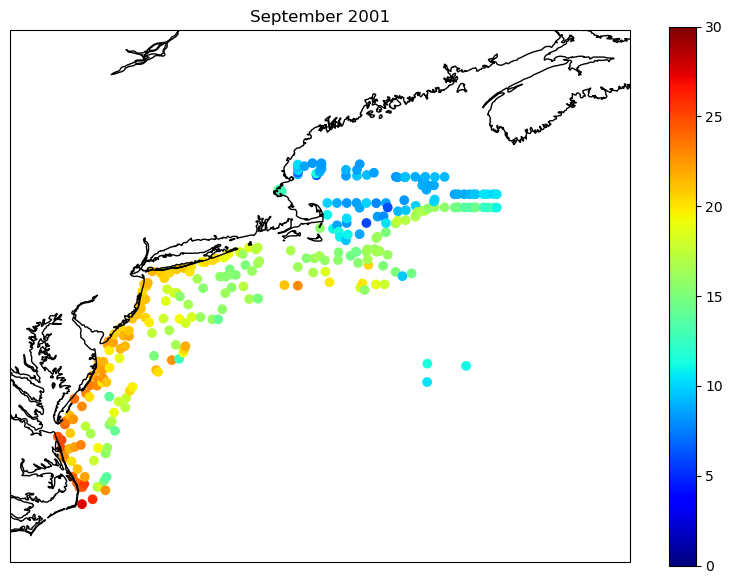

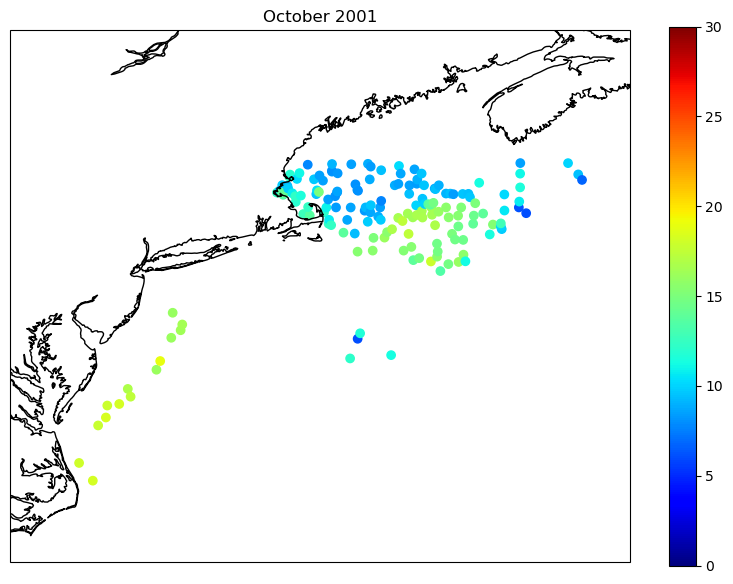

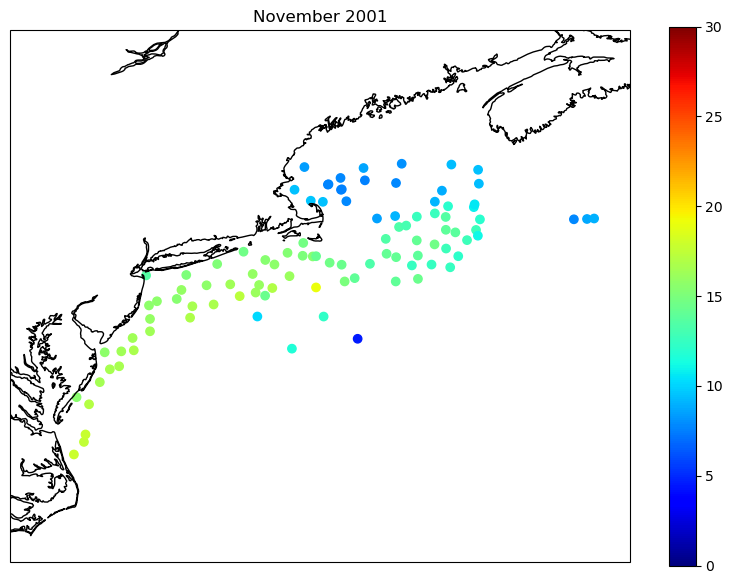

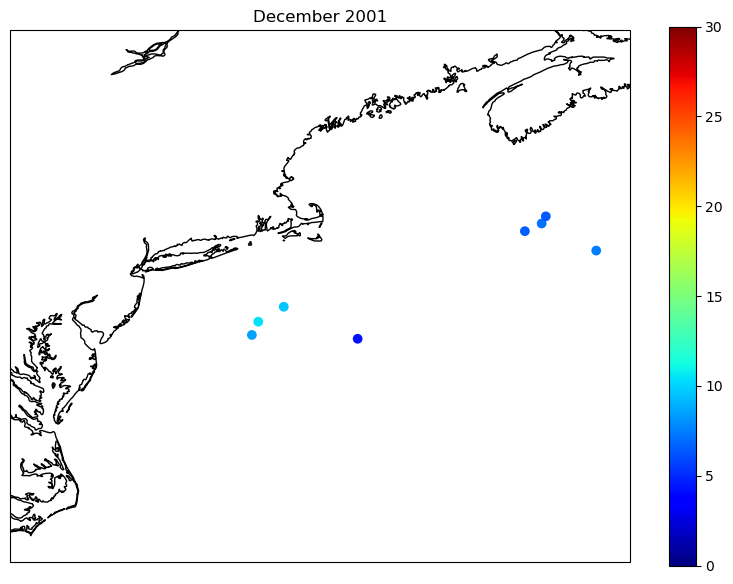

In [12]:
#PLOTTING WITH CARTOPY
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
for y in range(1,13):
    fig=  plt.figure(figsize=(10, 7)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-77, -63, 34, 46], crs=ccrs.PlateCarree())
    sc = plt.scatter(data[y].lon, data[y].lat, c=data[y].temp, cmap = 'jet', vmin=0, vmax=30) #, marker = 's')
    #ata.plot(column='temp', cmap='jet', edgecolor="black")
    ax.coastlines()
    plt.title(month_name[y]+' ' +str(year))
    plt.colorbar(sc)

### <font color='red'>**QUESTIONS**</font> <a class="anchor" id="eight"></a>
* <font color='red'>grid directly to the nc grid?</font> <a class="anchor" id="one"></a>
* <font color='red'>havent accounted for depth... averaging every data point found in that grid. Should I add code to bin by depth?</font> <a class="anchor" id="one"></a>

In [16]:
local_dir = r'C:\Users\haley.synan\Documents\SEASCAPES\CODE\PYTHON' #set local dir 
repo_url = "git@github.com:hsynan/NESCAPES_TEST.git" #REPO URL FROM GITHUB
proj_name = r'\NESCAPES_TEST'
branch_nm = 'main'
fname = ipynbname.name()
message = 'initial push of monthly_clima to repo'
gh_push_fname(local_dir, repo_url, branch_nm, fname, message)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'MONTHLY_CLIMA.ipynb'